In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm as norm
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

In [2]:
def perceptron(X,Y,eta=0.5,metric=False):
    if metric:
        delta = []
        I = []
        mistakes = 0
    
    i = 0
    w = np.zeros_like(X[0,:])
    for x,y in zip(X,Y):
        y_classifier = np.sign(np.sum(w*x))
        l = y - y_classifier
        w_new = w + eta*l*x
        if(metric and norm(w)>0):
            delta.append(norm(w_new/norm(w_new) - w/(norm(w))))
            I.append(i)
        if(metric and l!=0):
            mistakes = mistakes+1
        w = w_new
        i+=1
    if metric:
        return w, delta, I, mistakes
    else:
        return w

In [3]:
def winnow(X,Y, eta=0.001, metric=False):
    if metric:
        delta = []
        I = []
        mistakes = 0
        
    
    i = 0
    w = np.ones_like(X[0,:])
    w = w/np.sum(w)
    
    for x,y in zip(X,Y):
        l = y - np.sign(np.sum(w*x))
        if l != 0:
            w_new = w*np.exp(eta*x*y)
            w_new = w_new/np.sum(w_new)
            if(metric):
                mistakes = mistakes+1
            
            if(metric and norm(w)>0):
                delta.append(norm(w_new/norm(w_new) - w/(norm(w))))
                I.append(i)
            w = w_new
        i+=1
    
    if metric:
        return w, delta, I, mistakes
    else:
        return w

In [4]:
def prep_data(fname):
    d1 = pd.read_csv("./data/{}.csv".format(fname), sep=",", header=None)
    d = d1.values

    np.random.shuffle(d)
    X = d[:,:-1]
    Y = d[:,-1]

    #Adding the bias term
    X = np.c_[X, np.ones_like(X[:,0])]

    plus = np.where(Y==1)[0]
    minus = np.where(Y==-1)[0]
    return X, Y, plus, minus

#Due to the limitations of winnow, we have to adjust the data. We use the weights obtained 
#from the perceptron algorithm to adjust th input to the winnow algorithm
def prep_winnow_data(X,w):
    #w is the weights vector from the perceptron algo
    X_w = X*np.sign(w)  #Ensures that positive the seperating plane has positive weights
    w   = w*np.sign(w)
    n = w.size - 1
    X_w = X_w + (w[-1]/n)/w #Getting the seperating plane to pass through origin
    return X_w

In [5]:
def generate_results(fname, eta_w = 0.001):
    X,Y, plus, minus = prep_data(fname)
    w, delta, I, mistakes_p = perceptron(X,Y, metric = True)
    mc_p = np.sum(abs(Y-np.sign(np.sum(w*X,1))))/2
    
    X_w = prep_winnow_data(X,w)
    
    w_w, delta_w, I_w, mistakes_w = winnow(X_w,Y, eta=eta_w, metric = True)
    
    mc_w = np.sum(abs(Y-np.sign(np.sum(w_w*X_w,1))))/2
    n = Y.size
    
    perc_error = "Error for Perceptron in {0} data: \n \t Mistakes: {1}/{3} = {4:3.2f}% \n \t Misclassification by final model: {2:.0f}/{3} = {5:3.2f}%".format(fname,mistakes_p,mc_p,n,mistakes_p*100.0/n,mc_p*100.0/n)
    winnow_error = "Error for Winnow in {0} data: \n \t Mistakes: {1}/{3} = {4:3.2f}% \n \t Misclassification by final model: {2:.0f}/{3} = {5:3.2f}%".format(fname,mistakes_w,mc_w,n,mistakes_w*100.0/n,mc_w*100.0/n)
    
    fig, axs = plt.subplots(1,2, figsize=(20,8))
    axs[0].plot(I,delta)
    axs[1].plot(I_w,delta_w)
    
    axs[0].set_title("{}: Perceptron".format(fname), fontsize=24)
    axs[1].set_title("{}: Winnow with $\eta = {:.7f}$".format(fname,eta_w), fontsize=24)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[0].text(0.13, 0.97, perc_error, transform=axs[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    axs[1].text(0.13, 0.97, winnow_error, transform=axs[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    for ax in axs:
        ax.set_ylabel("Norm of change in direction of seperating plane", fontsize=20)
        ax.set_xlabel("$t$", fontsize=20)
    plt.savefig("{}.png".format(fname))
    plt.show()

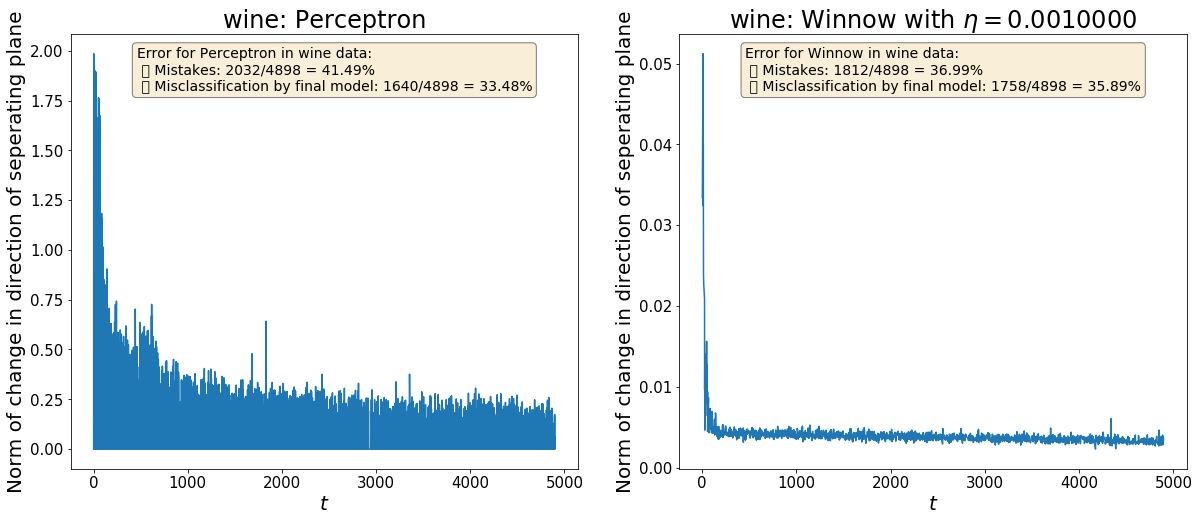

In [6]:
generate_results('wine',eta_w=1e-3)

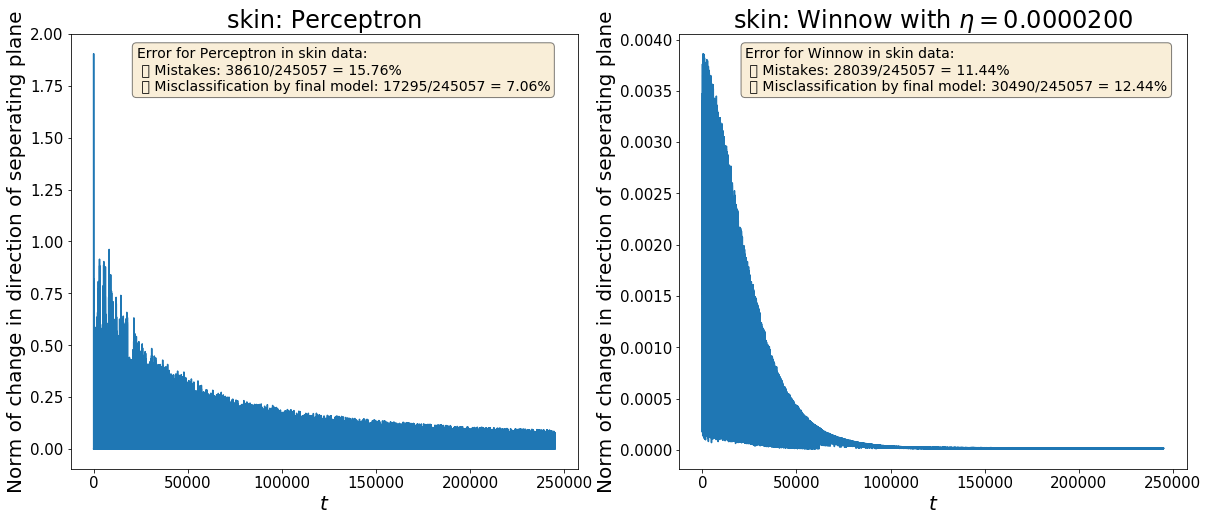

In [7]:
generate_results('skin', eta_w=2e-5)

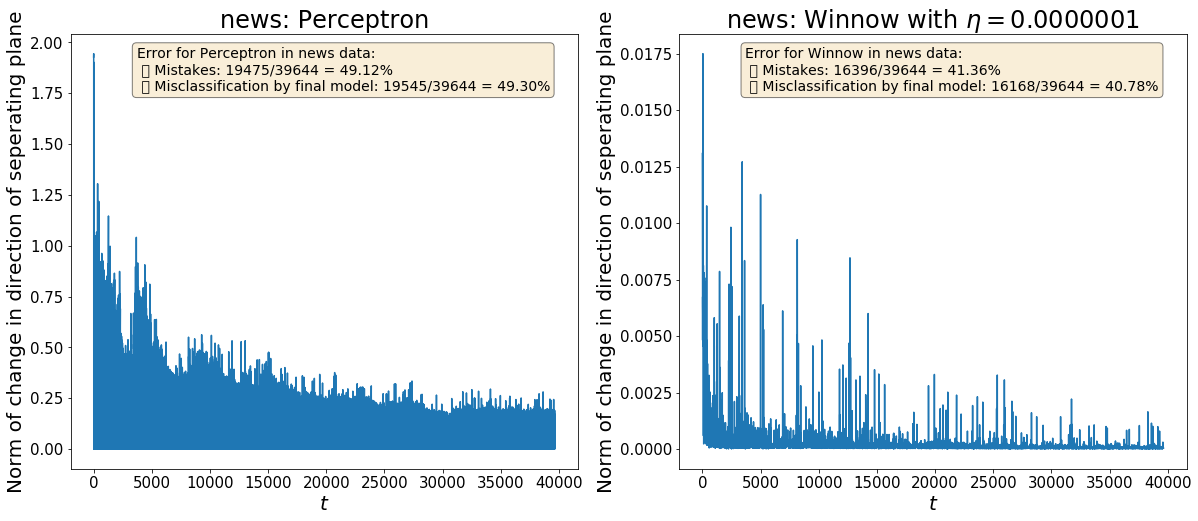

In [8]:
generate_results('news',eta_w=1e-7)